In [39]:
# !pip install tqdm
# !pip install scikit-learn
# !pip install "tensorflow==2.10"
# !pip install "numpy<2" --force-reinstall
# !pip install matplotlib
# !pip install torch
# !pip install opencv-python
# !pip install keras
# !pip install tensorflow

In [40]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())


True


In [41]:
print(tf.sysconfig.get_build_info())


OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [42]:
import numpy as np
import tensorflow as tf
import sys
import keras
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization,Conv2DTranspose,Concatenate,Input,Activation,Flatten,Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from  tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import torch
# from scipy.io import loadmat
# import h5py
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [43]:
# tf.sysconfig.get_build_info()


In [44]:
gpus=tf.config.list_physical_devices('GPU')
if gpus:
    print('GPU available')
else:
    print('GPU not available')
tf.config.list_physical_devices('GPU')

GPU available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [45]:
# import tensorflow as tf
#
# print("TF version:", tf.__version__)
# print("GPUs:", tf.config.list_physical_devices('GPU'))
#
# tf.debugging.set_log_device_placement(True)
#
# x = tf.random.normal([2048, 2048])
# y = tf.matmul(x, x)
# print("Done")

In [46]:
tf.debugging.set_log_device_placement(False)

In [47]:
dataset = "C:\IIT campus\Second Year\DSGP\Segementation_1\Segementation_1"

In [48]:
image_files = sorted(os.listdir('C:\Projects Datasets\Segmentation_1\Segmentation\\images'))
mask_files = sorted(os.listdir('C:\Projects Datasets\Segmentation_1\Segmentation\\masks'))

In [49]:
print(image_files[:10])
print(mask_files[:10])

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']


In [50]:
def display_image_mask(image_path,mask_path):
    count=0
    for image_file,mask_file in zip(image_files,mask_files):
        if count>=6:
            break
        image_path_full=os.path.join(image_path,image_file)
        mask_path_full=os.path.join(mask_path,mask_file)

        image=cv2.imread(image_path_full)
        mask=cv2.imread(mask_path_full,cv2.IMREAD_GRAYSCALE)

        if image is None:
                raise ValueError(f"Image at path {imagepath_full} could not be loaded")
        if mask is None:
                raise ValueError(f"Mask at path {maskpath_full} could not be loaded")

        mask_3ch=cv2.merge([mask,mask,mask])
        image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,10))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Mask')

        plt.subplot(1,3,3)
        overlay = cv2.addWeighted(image_rgb, 0.7, mask_3ch, 0.3, 0)
        plt.imshow(overlay)
        plt.title("Image with overlay")

        plt.show()
        count+=1

In [51]:
image_path='C:\Projects Datasets\Segmentation_1\Segmentation\\images'
mask_path='C:\Projects Datasets\Segmentation_1\Segmentation\\masks'

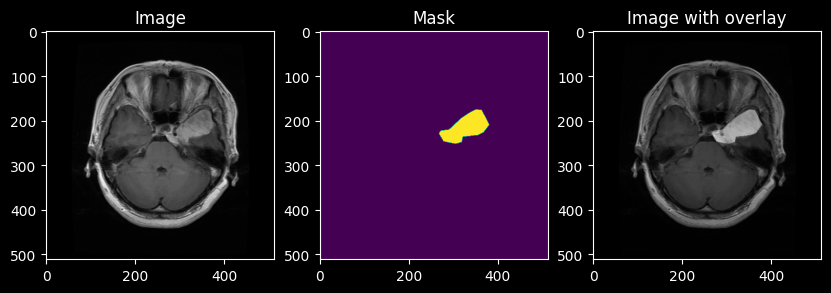

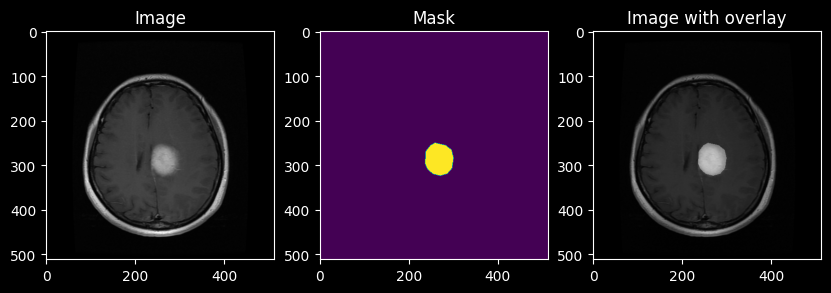

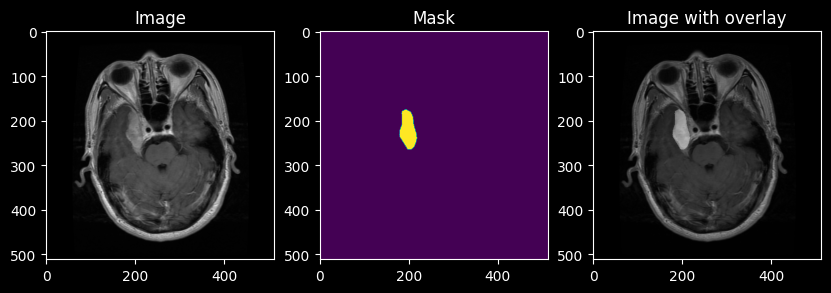

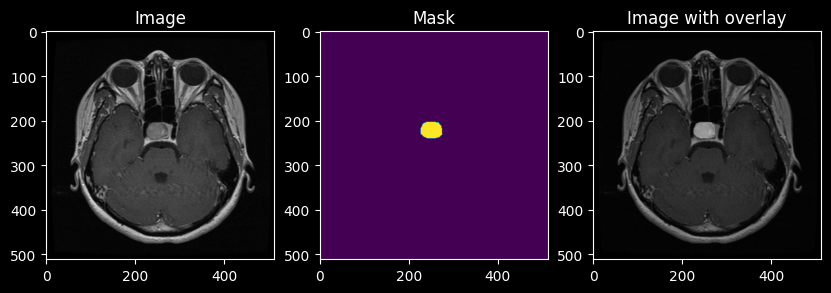

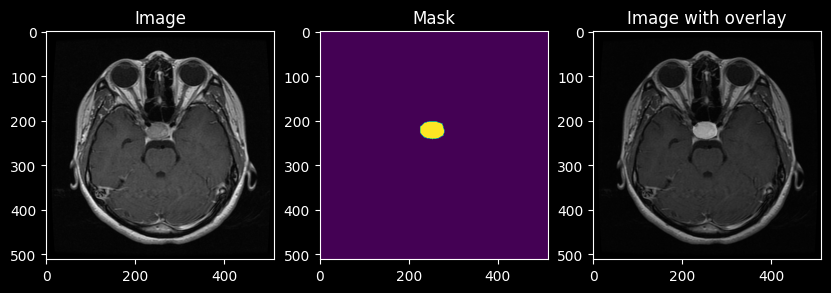

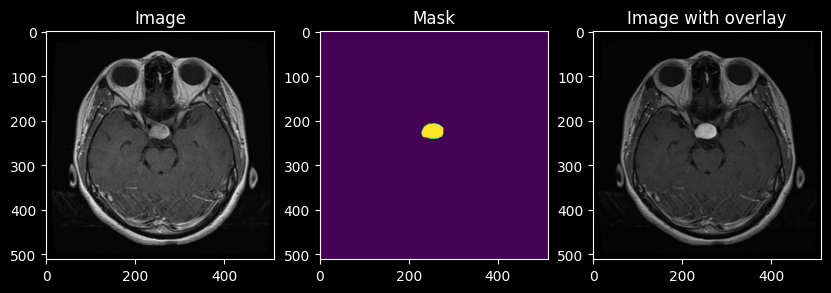

In [52]:
display_image_mask(image_path,mask_path)

In [53]:
images_size=[]
masks_size=[]
#Check images shape
for image_file, mask_file in tqdm(zip(image_files, mask_files)):

    imagepath_full = os.path.join(image_path, image_file)
    maskpath_full = os.path.join(mask_path, mask_file)

    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)

    images_size.append(image.shape)
    masks_size.append(mask.shape)

3052it [00:17, 178.44it/s]


In [54]:
print(list(set(images_size)))
print(list(set(masks_size)))

[(512, 512, 3), (256, 256, 3)]
[(512, 512, 3), (256, 256, 3)]


In [55]:
SIZE=224
CHANNEL=1


In [56]:
def preprocessing_images_masks(num_samples=None):
    images=[]
    masks=[]

    if num_samples is not None:
        selected_image_files = image_files[:num_samples]
        selected_mask_files = mask_files[:num_samples]
    else:
        selected_image_files = image_files
        selected_mask_files = mask_files

    for image_file, mask_file in tqdm(zip(selected_image_files, selected_mask_files)):
        imagepathfull=os.path.join(image_path,image_file)
        maskpathfull=os.path.join(mask_path,mask_file)

        image = cv2.imread(imagepathfull,cv2.IMREAD_GRAYSCALE)  #load img
        image = cv2.resize(image,(SIZE,SIZE))
        image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = image/255.0  #normalizes pixel values 0-1
        images.append(image)

        mask = cv2.imread(maskpathfull,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE,SIZE))
        mask = mask/255.0
        masks.append(mask)
    #add a channel to mask (depth of information per pixel(1))
    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

In [57]:
X,y=preprocessing_images_masks(num_samples=700)

700it [00:02, 279.69it/s]


In [58]:
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (700, 224, 224, 3)
Shape of y: (700, 224, 224, 1)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [60]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (560, 224, 224, 3)
The shape of y_train (560, 224, 224, 1)
The shape of X_test (140, 224, 224, 3)
The shape of y_test (140, 224, 224, 1)


In [62]:
#avoid division by zero
smooth = 1e-15

#decor- save custom function with model
# @keras.saving.register_keras_serializable()

@tf.keras.utils.register_keras_serializable(package="metrics")

#metric for overlap between prediction and ground truth
def dice_coef(y_true, y_pred):
    #convert multi dimensions to 1D
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)

    #common positive pixels
    intersection = tf.reduce_sum(y_true * y_pred)

    #balances TN and FP
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

# @register_keras_serializable()

@tf.keras.utils.register_keras_serializable(package="metrics")
#define loss function base one coef
def dice_loss(y_true, y_pred):
    #Reduce tumor mismatch
    return 1.0 - dice_coef(y_true, y_pred)

ValueError: metrics>dice_coef has already been registered to <function dice_coef at 0x0000017F4FACFF70>

In [ ]:
# tf.debugging.set_log_device_placement(True)

In [63]:
#data augmentation
train_datagen=(ImageDataGenerator
               (brightness_range=(0.9,1.1),#Randomly adjust brightness
               zoom_range=[.9,1.1],#Random zoom applied
               fill_mode='nearest') #Prevents unnatural
               )
val_datagen=ImageDataGenerator()

In [64]:
#extracts features and learn pattern from the input image
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input) #learn patterns
    x = BatchNormalization()(x)  #stabilizes training
    x = Activation("relu")(x)    #network to learn complex features.(Introduces non-linearity)

    #combine learn pattern into meaningful region
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [65]:
#increase resolution and merge encoder info in tumor mask
def decoder_block(input, skip_features, num_filters):
    #Upsampling (double spatial resolution)
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [66]:
def build_light_resnet50_unet(input_shape):
    inputs = Input(shape=input_shape)
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder (skip connections)
    s1 = inputs                                      # 224 x 224 x 3
    s2 = resnet50.get_layer("conv1_relu").output     # 112 x 112 x 64
    s3 = resnet50.get_layer("conv2_block3_out").output  # 56 x 56 x 256

    # Bridge(compressed view)
    b1 = resnet50.get_layer("conv3_block4_out").output  # 28 x 28 x 512

    # Decoder
    d1 = decoder_block(b1, s3, 128)   # 56 x 56
    d2 = decoder_block(d1, s2, 64)    # 112 x 112
    d3 = decoder_block(d2, s1, 32)    # 224 x 224

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

    model = Model(inputs, outputs, name="LightResNet50_U-Net")
    return model


input_shape = (224, 224, 3)
model = build_light_resnet50_unet(input_shape)
model.summary()

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in d

In [67]:
model_checkpoint  = ModelCheckpoint('best_model_checkpoint.keras', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

In [68]:
batch_size = 16

train_generator = train_datagen.flow( X_train, y_train, batch_size=batch_size, shuffle=True)

val_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

In [ ]:
# print(tf.__version__)
# print(tf.test.is_built_with_cuda())
#
# # tf.debugging.set_log_device_placement(True)
#
# with tf.device('/GPU:1'):
#     model = build_light_resnet50_unet((224,224,3))
#     model.compile(
#         optimizer='adam',
#         loss=dice_loss,
#         metrics=[dice_coef]
#     )
#
# history = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=50,
#     callbacks=callback_list
# )

In [69]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=dice_loss,
              metrics=[dice_coef, 'accuracy'])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [75]:
# history = model.fit(
#     X_train, y_train,
#     batch_size=16,  # Reduced from 32 to 4
#     epochs=100,
#     validation_data=(X_test, y_test),
#     verbose=2,
#     callbacks=callback_list
# )

# with tf.device('/GPU:0'):   # or '/GPU:1'
history = model.fit(
        X_train, y_train,
        batch_size=8,
        epochs=50,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=callback_list,

    )

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Option

ResourceExhaustedError: Graph execution error:

Detected at node 'LightResNet50_U-Net/batch_normalization_14/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\chanu\AppData\Local\Temp\ipykernel_20608\254731042.py", line 11, in <module>
      history = model.fit(
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\chanu\anaconda3\envs\tensorNewGPU\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'LightResNet50_U-Net/batch_normalization_14/FusedBatchNormV3'
OOM when allocating tensor with shape[8,64,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node LightResNet50_U-Net/batch_normalization_14/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_33336]

In [ ]:
model.save('resnet50_trained_model_batch_size_4.keras')


In [ ]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss,dice_coef,accuracy=model.evaluate(X_test,y_test)
print(f'Loss is {loss}')
print(f'Accuracy is {accuracy}')
print(f'Dice_Coef is {dice_coef}')

In [ ]:
model.save("unet_resnet50_backbone.keras")


In [ ]:
# from tensorflow.keras.models import load_model
#
# model = load_model(
#     "best_model_checkpoint_1",   # ← folder, NOT file
#     compile=False
# )

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

In [ ]:
for i in range(10):

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i],cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred[i].squeeze(), cmap='gray')

    plt.show()

In [ ]:
def overlay_mask(image, mask, alpha=0.4):
    # 1. Ensure the image is RGB even if it's grayscale
    if len(image.shape) == 2 or image.shape[-1] == 1:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image.copy()

    # 2. Create a red overlay
    overlay = image_rgb.copy()
    red_color = np.zeros_like(image_rgb)
    red_color[:, :] = [255, 0, 0]  # Set all mask pixels to Red

    # 3. Blend only where the mask exists
    mask_indices = mask > 0
    overlay[mask_indices] = (
        (1 - alpha) * image_rgb[mask_indices] +
        alpha * red_color[mask_indices]
    ).astype(np.uint8)

    return overlay

In [ ]:

n_show = 6
fig, axs = plt.subplots(n_show, 3, figsize=(12, 4 * n_show))

for i in range(n_show):

    # Image (already loaded)
    img = X_test[i]

    # If normalized, bring back to uint8 for display
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    # Ground truth mask
    gt_mask = y_test[i]
    if gt_mask.ndim == 3:
        gt_mask = gt_mask.squeeze()
    gt_mask = (gt_mask > 0.5).astype(np.uint8)

    # Prepare input for model
    input_img = img.astype(np.float32) / 255.0
    input_img = np.expand_dims(input_img, axis=0)

    # Predict mask
    pred_prob = model.predict(input_img, verbose=0)[0, :, :, 0]
    pred_mask = (pred_prob > 0.5).astype(np.uint8)

    # Overlay prediction
    overlay_img = overlay_mask(img, pred_mask)

    # Plot

    axs[i, 0].imshow(img, cmap="gray")
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(gt_mask, cmap="gray")
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(overlay_img)

    axs[i, 2].set_title("Predicted Overlay")
    axs[i, 2].axis("off")



plt.tight_layout()
plt.show()